**Task (1): Part(1) : graph engineering:**

importing required libraries.
we start by importing the necessary Python packages to handle data, build graphs, and visualize.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp


Data collection from https://lnctard.bio-database.com/Browser and https://string-db.org/



with the database from Lnctard you can explore all the lncRNA-genes associations.

In [2]:
# Load lncRNA-gene interactions
lnctard_df = pd.read_excel("data/lncRNA_Full_database.xlsx")



# Keep only rows where Regulator type is lncRNA
# the the node1 within this database is ALWAYS lncRNA

lnctard_df = lnctard_df[lnctard_df['RegulatorType'] == 'lncRNA']

# Rename and keep relevant columns
lnctard_df = lnctard_df.rename(columns={
     "Regulator": "node1",
     "Target": "node2",
     "regulatoryType": "interaction",
     "DiseaseName": "disease"
})

lnctard_df = lnctard_df.dropna(subset=["node1", "node2"])



# Remove all unnessasary columns from the database.
columns_to_keep = ['node1', 'node2', 'interaction', 'disease']
lnctard_df = lnctard_df[columns_to_keep]

lnctard_df["source"] = "lncRNA"

# Show first few rows after cleanup
print(lnctard_df.head())

# Save the filtered lnctard data in Exel file.
lnctard_df.to_excel("data/lnctard_Preprocessed_DB.xlsx", index=False)

print('lnctard_Preprocessed_DB was successfully created')

print("Row Numbers =", len(lnctard_df))

        node1     node2          interaction                      disease  \
0   LINC00313  miR-4429  binding/interaction  Papillary thyroid carcinoma   
1  FAM83H-AS1    CDKN1A           regulation             Malignant glioma   
2       NEAT1     TGFB1          association     Hepatocellular carcinoma   
3       NEAT1      ZEB1           regulation                Breast cancer   
4   ZFPM2-AS1       MIF  binding/interaction               Gastric cancer   

   source  
0  lncRNA  
1  lncRNA  
2  lncRNA  
3  lncRNA  
4  lncRNA  
lnctard_Preprocessed_DB was successfully created
Row Numbers = 7773


with the database from STRING you can explore all the genes-genes interactions.

We filtered the STRING dataset using a threshold of 550 on the combined_score column. This threshold is a good balance between high confidence interactions and retaining enough data for meaningful graph structure. STRING recommends 400+ for medium confidence and 700+ for high confidence; 550 sits in the confident range without excessive filtering.

Mapping ENSP IDs to Gene Names: We used UniProt to convert STRING's ENSP identifiers to standard gene names. Out of 18,703 unique ENSP IDs, we successfully mapped 18,411 to gene names.

Handling Missing or Ambiguous Mappings:We discarded 292 ENSP IDs that had no mapping on UniProt. For ENSP IDs with multiple gene name mappings, we selected the most commonly recognized gene name (the primary entry).

Null Cleanup: Any row in the dataset with a missing node1 or node2 value was excluded from the final graph to ensure consistency and completeness.


In [ ]:
## can't upload string_Full_database.txt on github because it's large size.
## you can find the file here https://drive.google.com/file/d/14ye5c763D6BsZGKYVU_PtYoo-26Kl5VL/view?usp=sharing if you want to try it locally.
## will add the result file from this node (filtered_STRING_data.xlsx) directly in the data folder.


"""
# read the file with all database from STRING. it's really BIG more than 995 MB   
#df = pd.read_csv("/data/String_Full_database.txt", sep=" ")

# 13715404 rows in the original database
print("Row Numbers =", len(df))

# print the first 5 rows to see the structure.
print("The First five rows:")
print(df.head())

# print Columns names to get get familiar with the structure.
print("Columns Names:", df.columns.tolist())

# set a threshold to reduce the Noise and get more sutable data size(score ≥ 400)
filtered_df = df[df["combined_score"] >= 550]

# 891390 in the filtered database.
print("Numbers of rows after Filtering", len(filtered_df))

# Save the filtered data in Exel file.
filtered_df.to_excel("/data/filtered_STRING_data.xlsx", index=False)

print("the file filtered_STRING_data.xlsx saved successfully")
"""



In [ ]:
# Show first few rows filtered_STRING_data.xlsx
#filtered_df.head()

now we need to take the unique ENSP and write them to txt file to upload it in UNIPROT for mapping

In [3]:

df = pd.read_excel("data/filtered_STRING_data.xlsx")

# Get unique values from both columns
unique_col1 = set(df['protein1'].dropna().unique())
unique_col2 = set(df['protein2'].dropna().unique())

# Combine and sort the unique values
all_unique_values = sorted(unique_col1.union(unique_col2))

file_path = 'data/Unique_ENSP.txt'

# create empty txt file
with open(file_path, 'w') as f:
      pass

# Save the unique ENSP to text file
with open('data/Unique_ENSP.txt', 'w') as f:
      for value in all_unique_values:
          f.write(f"{value}\n")

print(f"Success! Found {len(all_unique_values)} unique values.")
print(f"Results saved to: {'data/Unique_ENSP.txt'}")



Success! Found 18703 unique values.
Results saved to: data/Unique_ENSP.txt


In [4]:
# Read txt file and print first few lines
with open('data/Unique_ENSP.txt', 'r') as f:
    for i in range(5):  # Read first 5 lines
        line = f.readline()
        print(line.strip())

9606.ENSP00000000233
9606.ENSP00000000412
9606.ENSP00000001008
9606.ENSP00000001146
9606.ENSP00000002125


upload the Unique_ENSP.txt file to UNIPROT for mapping 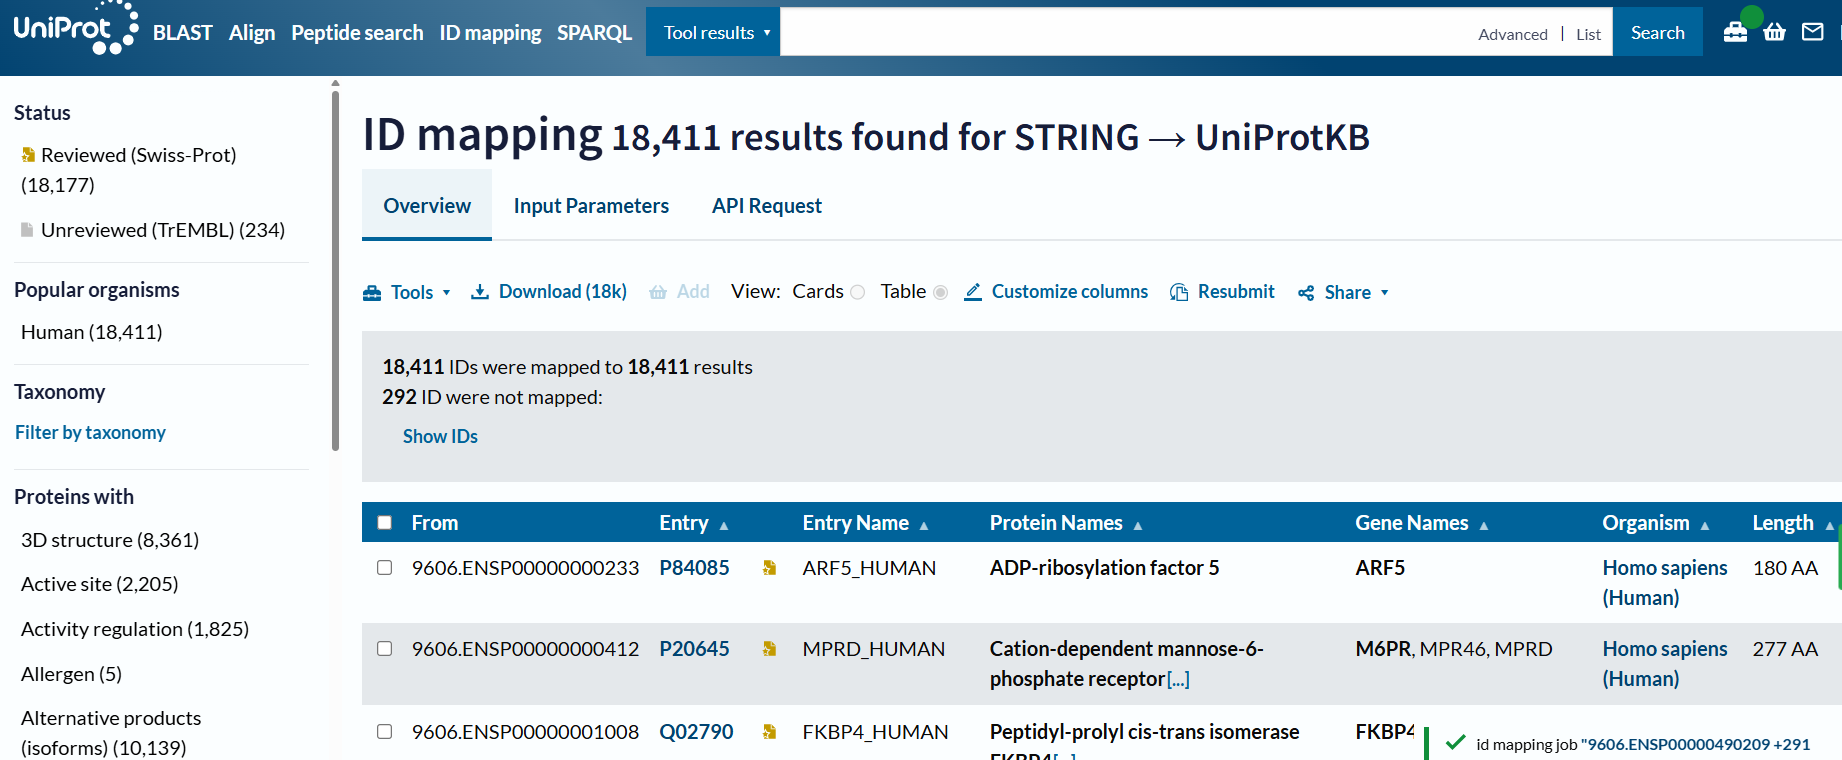


From 18703 Unique ENSP we can map 18411 successfully using UNIPROT and 292 ENSP not mapped.

downloaded the result file as ENSP_to_geneName.xlsx and saved it into the data folder.

as we can see in the image above there are some ENSP maps to more than one gene names. after search we find that the first gene name is the most important, popular one. so we just take the first gene neme and discard the other names.

In [5]:
uniprot_df = pd.read_excel("data/ENSP_to_geneName.xlsx")

# Show first few rows
uniprot_df.head()



,From,Entry,Entry Name,Gene Names
0,9606.ENSP00000000233,P84085,ARF5_HUMAN,ARF5
1,9606.ENSP00000000412,P20645,MPRD_HUMAN,M6PR MPR46 MPRD
2,9606.ENSP00000001008,Q02790,FKBP4_HUMAN,FKBP4 FKBP52
3,9606.ENSP00000001146,Q9NR63,CP26B_HUMAN,CYP26B1 CYP26A2 P450RAI2
4,9606.ENSP00000002125,Q7L592,NDUF7_HUMAN,NDUFAF7 C2orf56 PRO1853


In [6]:
# take the coloumns we need and drop the rest
uniprot_df = uniprot_df[["From", "Gene Names"]]

# take  nor the first gene name.
uniprot_df["Gene Symbol"] = uniprot_df["Gene Names"].str.split().str[0]

# prepare new file to use it in mapping ENSP ID → Gene Symbol
mapping_df = uniprot_df[["From", "Gene Symbol"]]


mapping_df.to_excel("data/ENSP_to_GeneSymbol_Cleaned.xlsx", index=False)

print("ENSP_to_GeneSymbol_Cleaned.xlsx was successfully created")


ENSP_to_GeneSymbol_Cleaned.xlsx was successfully created


In [7]:
mapping_df.head()

,From,Gene Symbol
0,9606.ENSP00000000233,ARF5
1,9606.ENSP00000000412,M6PR
2,9606.ENSP00000001008,FKBP4
3,9606.ENSP00000001146,CYP26B1
4,9606.ENSP00000002125,NDUFAF7


merge ENSP_to_GeneSymbol_Cleaned.xlsx file with filtered_STRING_data.xlsx file to covert ENSP to unique gene name in STRING database

In [8]:
interactions = pd.read_excel("data/filtered_STRING_data.xlsx")
mapping = pd.read_excel("data/ENSP_to_GeneSymbol_Cleaned.xlsx")

# first mapping protein1 → gene1
merged1 = interactions.merge(mapping, how="inner", left_on="protein1", right_on="From")
merged1 = merged1.rename(columns={"Gene Symbol": "gene1"}).drop("From", axis=1)

# now map protein2 → gene2 (use mapping file again)
merged_final = merged1.merge(mapping, how="inner", left_on="protein2", right_on="From")
merged_final = merged_final.rename(columns={"Gene Symbol": "gene2"}).drop("From", axis=1)

# keep only relevant columns
final_df = merged_final[["gene1", "gene2", "combined_score"]]

# save to Excel
final_df.to_excel("data/STRING_Preprocessed_DB.xlsx", index=False)

print("STRING_Preprocessed_DB.xlsx was successfully created")
final_df.head()

STRING_Preprocessed_DB.xlsx was successfully created


,gene1,gene2,combined_score
0,ARF5,GGA1,594
1,ARF5,RAB1B,648
2,ARF5,ERP44,582
3,ARF5,GNB2,563
4,ARF5,CYTH4,618


In [9]:
#number of rows of STRING DB after all preprocessing
print(len(final_df))

866856


finally we want to merge the lnctard database and STRING database

In [10]:
lnctard_df.head()

,node1,node2,interaction,disease,source
0,LINC00313,miR-4429,binding/interaction,Papillary thyroid carcinoma,lncRNA
1,FAM83H-AS1,CDKN1A,regulation,Malignant glioma,lncRNA
2,NEAT1,TGFB1,association,Hepatocellular carcinoma,lncRNA
3,NEAT1,ZEB1,regulation,Breast cancer,lncRNA
4,ZFPM2-AS1,MIF,binding/interaction,Gastric cancer,lncRNA


In [11]:
final_df.head()

,gene1,gene2,combined_score
0,ARF5,GGA1,594
1,ARF5,RAB1B,648
2,ARF5,ERP44,582
3,ARF5,GNB2,563
4,ARF5,CYTH4,618


In [13]:
final_df = final_df.rename(columns={
    "gene1": "node1",
    "gene2": "node2",
    "combined_score": "interaction"
})
final_df["source"] = "PPI"
final_df["disease"] = None

# merge two databases
merged_all = pd.concat([lnctard_df, final_df], ignore_index=True)

#remove rows with missing values at node1 or node2
clean_df = merged_all.dropna(subset=["node1", "node2"])


clean_df.to_excel("data/merged_lnctard_STring.xlsx", index=False)

print("merged preprocessed databases with total number of rows = ")
print(len(clean_df))


merged preprocessed databases with total number of rows = 
871057


In [15]:
clean_df.head()

,node1,node2,interaction,disease,source
0,LINC00313,miR-4429,binding/interaction,Papillary thyroid carcinoma,lncRNA
1,FAM83H-AS1,CDKN1A,regulation,Malignant glioma,lncRNA
2,NEAT1,TGFB1,association,Hepatocellular carcinoma,lncRNA
3,NEAT1,ZEB1,regulation,Breast cancer,lncRNA
4,ZFPM2-AS1,MIF,binding/interaction,Gastric cancer,lncRNA


now we have 871057 cleaned rows to build our graph but it will be a very huge graph which we can't see it clearly on our screen. it will be very crowded.

the more realistic solution to calculate the graph matrices instead of drawing or draw a small sub graph.

In [16]:
## you can run directrly this node to work with the final database :)

print('Start reading the final database')
clean_df = pd.read_excel("data/merged_lnctard_STring.xlsx")
print('READy to use final database to work with GRAPH!!')


Start reading the final database
READy to use final database to work with GRAPH!!


In [17]:
print(clean_df.head())

        node1     node2          interaction                      disease  \
0   LINC00313  miR-4429  binding/interaction  Papillary thyroid carcinoma   
1  FAM83H-AS1    CDKN1A           regulation             Malignant glioma   
2       NEAT1     TGFB1          association     Hepatocellular carcinoma   
3       NEAT1      ZEB1           regulation                Breast cancer   
4   ZFPM2-AS1       MIF  binding/interaction               Gastric cancer   

   source  
0  lncRNA  
1  lncRNA  
2  lncRNA  
3  lncRNA  
4  lncRNA  


In [18]:
G = nx.Graph()

for _, row in clean_df.iterrows():
    G.add_node(row["node1"], type="lncRNA" if row["source"] == "lncRNA" else "protein") # node1 can be lncRNA or protein
    G.add_node(row["node2"], type="protein") # node2 always protien

    # add edge between node1 and node2 and add information (interaction and disease name) about relation
    G.add_edge(row["node1"], row["node2"], interaction=row["interaction"], disease=row["disease"])

# Graph metrics

print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

# number of connected components
components = list(nx.connected_components(G))
print("Connected components:", len(components))

# number of nodes in the largest connected component.
print("Largest component size:", len(max(components, key=len)))

# average number of nodes which connected to each node
avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", round(avg_deg, 2))

# check graph Density
print("Density:", round(nx.density(G), 4))


print("\nTop 10 high-degree nodes:")

# top central nodes (degree)
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_nodes:
    print(f"{node}: {degree}")

Total nodes: 20232
Total edges: 437348
Connected components: 72
Largest component size: 20085
Average degree: 43.23
Density: 0.0021

Top 10 high-degree nodes:
TP53: 1333
AKT1: 961
EGFR: 930
CTNNB1: 929
ACTB: 874
PRKACA: 826
SRC: 818
MYC: 805
TNF: 804
PRKACB: 803


we will draw here subgraph for one of the mostest important node (TP53) and its neighbors.

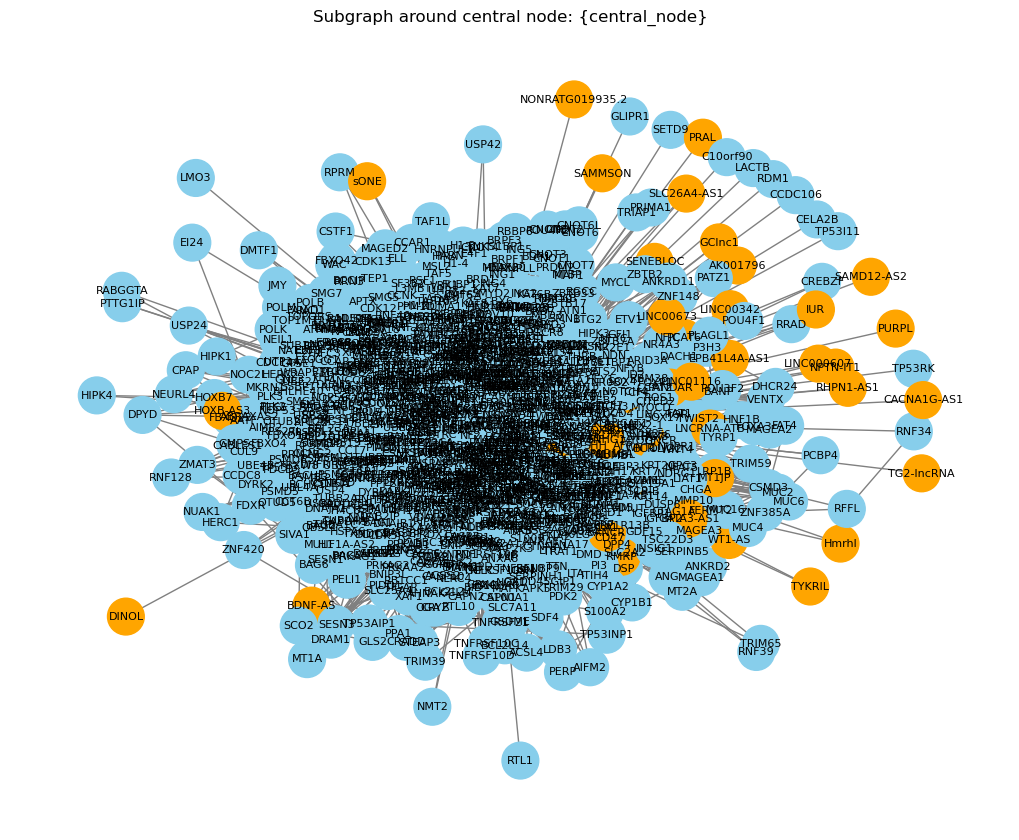

In [19]:
# draw neighbors of a central hub node (TP53)

# Select a central hub node to visualize its neighborhood
central_node = "TP53"

# Get all nodes directly connected to the central node (its neighbors)
neighbors = list(G.neighbors(central_node))

# Include the central node itself
sub_nodes = [central_node] + neighbors

# Create the subgraph based on selected nodes
subgraph = G.subgraph(sub_nodes)

# Assign node colors based on type (lncRNA vs protein)
color_map = ['orange' if subgraph.nodes[n]['type'] == 'lncRNA' else 'skyblue' for n in subgraph.nodes]

# Draw the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_color=color_map,
    node_size=700,
    font_size=8,
    edge_color='gray'
)
plt.title("Subgraph around central node: {central_node}")
plt.show()

Now The graph structure is suitable for Graph Neural Network (GNN) applications !! :)